# Exploraty Data Analysis
### Blaine Murphy
### July 2021
I will examine the cleaned data to look for relationships, trends and potentially corellating features.

A few ideas to get me started:
    1.  Maps of traps, spray, and weather stations to understand aerial distribution of the data
    2.  Explore training mosquito trap data set to understand the if mosquitos & WNV are more prevelant in any part of the city and at any specific time of year.  
    3. Create features from spray and weather data and merge to training data and explore trends

The Notebook roughly follows the following outline:
1. Loading data
2. Map of data to form understanding of aerial distribution
3. Test if WNV cases are more likely with a higher number of mosquitos in the trap
4. Analysis of Mosquitos/WNV and weather data through time
5. Interactive plot of Mosquitos and WNV cases on a map through time
6. Merging of train and weather data sets using a few different aggregation windows.
7. High level analysis of aggregated weather features
8. Distribution plots looking for features that could predict WNV case
10. Interactive plot looking at the influence of certain weather events
11. Summary

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import random
from scipy import stats
import datetime as dt
import matplotlib.colors as pltcolors
import re


In [2]:
### Load data
train = pd.read_csv('train_clean.csv',index_col=0)
weather = pd.read_csv('weather_clean.csv',index_col=0)
spray = pd.read_csv('spray_clean.csv')
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

Firstly I will map the locations of relevant data

In [3]:
### For constructing the map display
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

Isolate map data and plot data on the map background

In [4]:
spray_loc = spray[['Latitude','Longitude']].drop_duplicates()
traps_loc = train[['Latitude','Longitude']].drop_duplicates()
station_loc = weather[['StationLat','StationLong']].drop_duplicates()

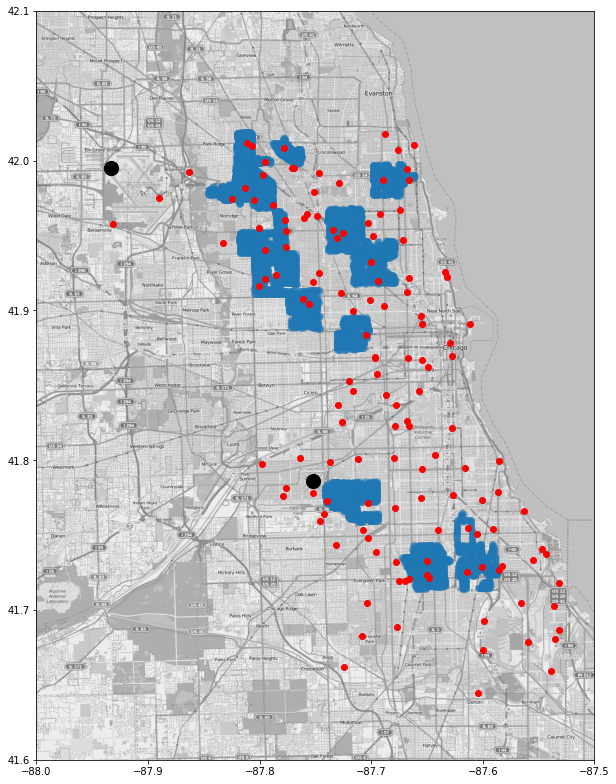

In [5]:
###  Plot mosquito traps data 

plt.figure(figsize=(10,14))
plt.imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)

plt.scatter(x=spray_loc.Longitude,y=spray_loc.Latitude,alpha=.3)
plt.scatter(x=traps_loc.Longitude,y=traps_loc.Latitude,color='red')
plt.scatter(x=station_loc.StationLong,y=station_loc.StationLat,s=200,color='black')


plt.show()

~~Oh no there are some more bad `spray` data points.  I will go back to my data wrangling notebook and fix these.~~

The map looks great, but I am already noticing that the two weather stations (black spots above) are not ideally placed realtive to the traps. 

now I'll dig further into the data

### First I will explore the mosquito traps data by itself

In [6]:
train['Date'] = pd.to_datetime(train['Date'])
train.set_index('Date',inplace=True,drop=True)
train.head()


,Trap,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,RESTUANS,PIPIENS,SALINARIUS,TERRITANS,TARSALIS,ERRATICUS,NumMosquitos,WnvPresent
Date,,,,,,,,,,,,,,,,
2007-05-29,T002,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,1,0,0,0,0,2,0.0
2007-05-29,T007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,0,0,1,0.0
2007-05-29,T015,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,1,0,0,0,0,5,0.0
2007-05-29,T045,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,1,0,0,0,0,0,2,0.0
2007-05-29,T046,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,0,0,0,0,1,0.0


In [7]:
### How many positive WNV cases are in the trap data
train.WnvPresent.value_counts()/train.shape[0]

0.0    0.916594
1.0    0.083406
Name: WnvPresent, dtype: float64

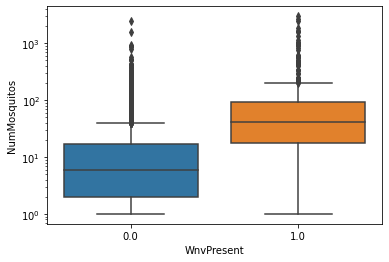

In [8]:
### Are the odds of getting WNV in the sample related
### to the number of mosquitos in the sample?
### If so I can use any feature that could help predict number of mosquitos
### to help predict virus present

sns.boxplot(data=train,x='WnvPresent',y='NumMosquitos')
plt.yscale('log')
plt.show()

Only 8% of samples in the training set tested positive for WNV.  As I saw before the data is imbalanced but a little bit less so after consolidating records. 

At first glance of the box plot it appears that the greater the number of mosquitos in the sample the more likely there is to be a positive WNV case.  I'll formally test this now (maybe quick logistic regression?). 


In [9]:
train.groupby('WnvPresent')['NumMosquitos'].describe()

,count,mean,std,min,25%,50%,75%,max
WnvPresent,,,,,,,,
0.0,4231.0,19.690617,65.472792,1.0,2.0,6.0,17.0,2479.0
1.0,385.0,134.358442,330.989373,1.0,18.0,41.0,92.0,3002.0


p-value: 0.0


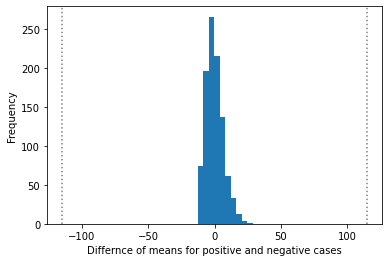

In [10]:
### Permutation test for differnce of means

means = []
for _ in range(1000):
    train['Perm'] = np.random.permutation(train.NumMosquitos)
    means.append(train.loc[train.WnvPresent==1,'Perm'].mean() -  train.loc[train.WnvPresent==0,'Perm'].mean())
means = np.array(means)
diff = abs(134.358-19.691)
p=(np.sum(means >= diff)+np.sum(means<=diff*-1))/len(means)
print('p-value: {}'.format(p))
train.drop('Perm',axis=1,inplace=True)
plt.hist(means)
plt.axvline(diff,c='grey',linestyle=':')
plt.axvline(diff*-1,c='grey',linestyle=':')
plt.xlabel('Differnce of means for positive and negative cases')
plt.ylabel('Frequency')
plt.show()

According to the permutation test there is ~0% chance that the mean number of mosquitos in a sample that tests positive is the same as those that test negative given this data.  I can reject the null hypothesis that the two means are equal, and conclude that the more mosquitos caught in a trap, the higher the likelihood that sample will test positive for the virus.  This may help in choosing predictive features. 

Now I will explore how mosquito traps through time. 

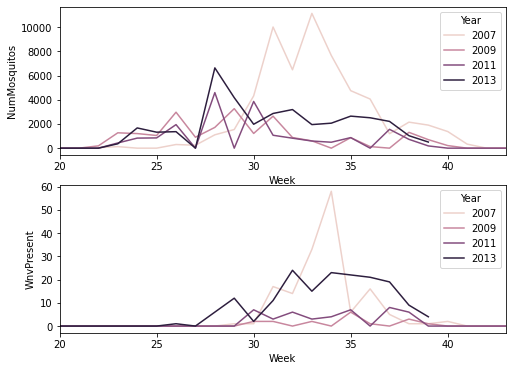

In [11]:
### Aggregate data weekly and make plots of mosquitos over time

trainplot = train.resample('W').sum()
train.index.isocalendar().week
trainplot['Month'] = trainplot.index.month
trainplot['Week'] = trainplot.index.isocalendar().week
trainplot['Year'] = trainplot.index.year

trainplot = trainplot[trainplot.Year.isin([2007,2009,2011,2013])]

fig,axes = plt.subplots(2,1,figsize = (8,6))


sns.lineplot(data=trainplot,x='Week',y='NumMosquitos',hue='Year',ax=axes[0])

sns.lineplot(data=trainplot,x='Week',y='WnvPresent',hue='Year',ax=axes[1])

for i in [0,1]: axes[i].set_xlim((20,43))

plt.show()



A couple observations:
    - 2007 was a bad year for mosquitos and WNV positive cases, especially for the weeks 30-35 (around August). 
    - 2013 (really August '13) was also a bad year for WNV even though the number of mosquitos caught in the traps was not significantly more than in 2009 and 2011
    - There was an early spike of mosquitos and WNV around week 28 of 2013. Were there any remarkable weather events then?
    
I will add some features to the train dataset based on `Date` to be used in the model. Also, I will check the `weather` data to see what was going on during these peaks.  

In [12]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Week'] = train.index.isocalendar().week
train['Week'] = train['Week'].astype('int')

I will make plots of the weather data for these years to see if something jumps out in August 2007.  From my experience mosquitos thrive in hot humid environments after a rainy spell so there is a lot of standing water.  I will make weather plots across time to see if I can see such condtions during a WNV peak.  

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Station         2944 non-null   int64  
 1   Date            2944 non-null   object 
 2   Tmax            2944 non-null   int64  
 3   Tmin            2944 non-null   int64  
 4   Tavg            2944 non-null   int64  
 5   Depart          2944 non-null   float64
 6   DewPoint        2944 non-null   int64  
 7   WetBulb         2944 non-null   int64  
 8   Heat            2944 non-null   int64  
 9   Cool            2944 non-null   int64  
 10  CodeSum         2944 non-null   object 
 11  PrecipTotal     2944 non-null   float64
 12  StnPressure     2944 non-null   float64
 13  SeaLevel        2944 non-null   float64
 14  AvgSpeed        2944 non-null   float64
 15  Sunrise(hrs)    2944 non-null   float64
 16  Sunset(hrs)     2944 non-null   float64
 17  WindDirection   2944 non-null   i

In [14]:
### Aggregate weather weekly 
weather['Date'] = pd.to_datetime(weather['Date'])
weather_weekly = weather[weather.Station==1].set_index('Date')
weather_weekly['Tnormal'] = weather_weekly['Tavg']-weather_weekly['Depart']

agg_funcs = {'WetBulb':np.mean,'StnPressure':np.mean,'WindSpeed':np.mean,\
             'Tavg':np.mean,'Tmax':np.mean,'Tmin':np.mean,\
             'DewPoint':np.mean,'PrecipTotal':'sum','Depart':np.mean,'Tnormal':np.mean}
weather_weekly = weather_weekly.resample('W-Mon').agg(agg_funcs)
weather_weekly['Week'] = weather_weekly.index.isocalendar().week
weather_weekly['Month'] = weather_weekly.index.month
weather_weekly['Year'] = weather_weekly.index.year

weather_weekly = weather_weekly[weather_weekly.Year.isin([2007,2009,2011,2013])]


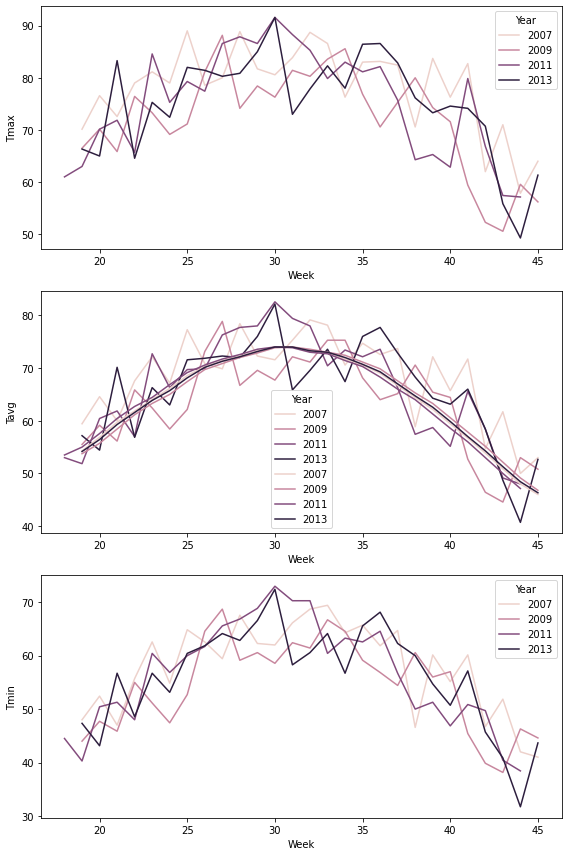

In [15]:
fig,axes=plt.subplots(3,1,figsize = (8,12),tight_layout=True)

sns.lineplot(data=weather_weekly,x='Week',y='Tmax',hue='Year',ax=axes[0])
sns.lineplot(data=weather_weekly,x='Week',y='Tavg',hue='Year',ax=axes[1])
sns.lineplot(data=weather_weekly,x='Week',y='Tnormal',hue='Year',ax=axes[1])
sns.lineplot(data=weather_weekly,x='Week',y='Tmin',hue='Year',ax=axes[2])

#for i in range(3): axes[i].set_xlim(4,11)

plt.show()

Three different measures of daily temperature aggregated weekly all look about the same.  I probably don't neet to include more than one

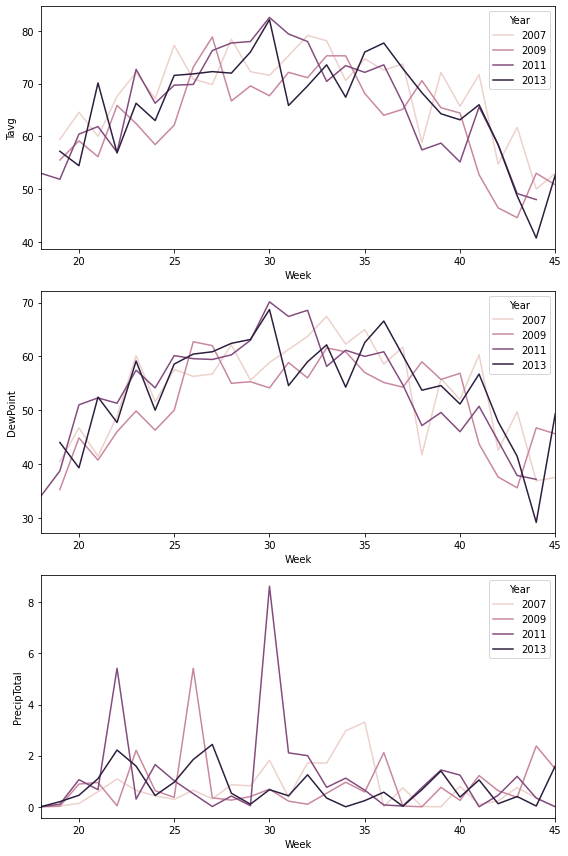

In [16]:
fig,axes=plt.subplots(3,1,figsize = (8,12),tight_layout=True)

sns.lineplot(data=weather_weekly,x='Week',y='Tavg',hue='Year',ax=axes[0])

sns.lineplot(data=weather_weekly,x='Week',y='DewPoint',hue='Year',ax=axes[1])

sns.lineplot(data=weather_weekly,x='Week',y='PrecipTotal',hue='Year',ax=axes[2])

for i in range(3): axes[i].set_xlim(18,45)

plt.show()

A couple things of note.  Dew point seems to be quite high in 2011 & 2013 around week 30, which is a time of increased mosquito populations in those years.  In 2007 the Dew point is also quite high from week 31 to 35, the same time as that years spike in mosquitos and WNV positive tests.  Total precipitation in 2007 seems to parallel the weekly WNV cases.  That could be a useful predictive feature.   

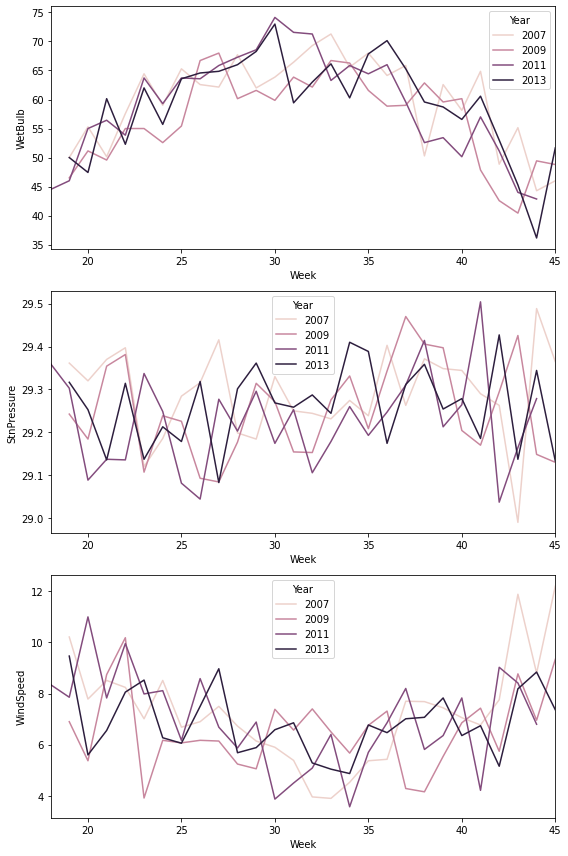

In [17]:
fig,axes=plt.subplots(3,1,figsize = (8,12),tight_layout=True)

sns.lineplot(data=weather_weekly,x='Week',y='WetBulb',hue='Year',ax=axes[0])
sns.lineplot(data=weather_weekly,x='Week',y='StnPressure',hue='Year',ax=axes[1])
sns.lineplot(data=weather_weekly,x='Week',y='WindSpeed',hue='Year',ax=axes[2])

for i in range(3): axes[i].set_xlim(18,45)

plt.show()

The `WetBulb` plot looks very similar to the `DewPoint`.  From a bit of reading they are similar measurements, so I probably don't need both.  Nothing jumps out on the `StnPressure` as related to the peaks in mosquitos or WNV.  The `WindSpeed` seems to be inversely correlated to the number of mosquitos.  In 2011 there is a low average wind speed in week 30 and an uptick in mosquitos and WNV.  In 2007 there is low average wind speed from week 31 to week 35, exactly when the mosquito/WNV spikes occured that year.  I'll create features for how prevealent historically mosquitos tend to be during different months and weeks. 

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4616 entries, 2007-05-29 to 2013-09-26
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Trap                    4616 non-null   object 
 1   Address                 4616 non-null   object 
 2   Block                   4616 non-null   int64  
 3   Street                  4616 non-null   object 
 4   AddressNumberAndStreet  4616 non-null   object 
 5   Latitude                4616 non-null   float64
 6   Longitude               4616 non-null   float64
 7   AddressAccuracy         4616 non-null   int64  
 8   RESTUANS                4616 non-null   int64  
 9   PIPIENS                 4616 non-null   int64  
 10  SALINARIUS              4616 non-null   int64  
 11  TERRITANS               4616 non-null   int64  
 12  TARSALIS                4616 non-null   int64  
 13  ERRATICUS               4616 non-null   int64  
 14  NumMosquitos          

In [19]:
train = train.reset_index()

yearly_cases = (train[['Year','Month','Week','WnvPresent']].\
                groupby('Year').sum()/\
                train[['Year','Month','Week','WnvPresent']].\
                groupby('Year').count())[['WnvPresent']]
yearly_cases = yearly_cases.rename(columns={"WnvPresent":"WnvPerc_yearly"})

monthly_cases = (train[['Year','Month','Week','WnvPresent']]\
                .groupby(['Month']).sum()/\
                train[['Year','Month','Week','WnvPresent']].\
                 groupby('Month').count())[['WnvPresent']]
monthly_cases = monthly_cases.rename(columns={"WnvPresent":"WnvPerc_monthly"})

weekly_cases = (train[['Year','Month','Week','WnvPresent']]\
                .groupby('Week').sum()/\
                train[['Year','Month','Week','WnvPresent']].\
                 groupby('Week').count())[['WnvPresent']]
weekly_cases = weekly_cases.rename(columns={"WnvPresent":"WnvPerc_weekly"})

train = train.merge(yearly_cases,how='left', on='Year',validate='m:1')
train = train.merge(monthly_cases,how='left', on='Month',validate='m:1')
train = train.merge(weekly_cases,how='left', on='Week',validate='m:1')
train = train.set_index('Date',drop=False)
train.head()

,Date,Trap,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,RESTUANS,...,TARSALIS,ERRATICUS,NumMosquitos,WnvPresent,Year,Month,Week,WnvPerc_yearly,WnvPerc_monthly,WnvPerc_weekly
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,2007-05-29,T002,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,...,0,0,2,0.0,2007,5,22,0.106237,0.0,0.0
2007-05-29,2007-05-29,T007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,...,0,0,1,0.0,2007,5,22,0.106237,0.0,0.0
2007-05-29,2007-05-29,T015,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,...,0,0,5,0.0,2007,5,22,0.106237,0.0,0.0
2007-05-29,2007-05-29,T045,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,1,...,0,0,2,0.0,2007,5,22,0.106237,0.0,0.0
2007-05-29,2007-05-29,T046,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,...,0,0,1,0.0,2007,5,22,0.106237,0.0,0.0


Perfect.  Now I have features that capture the expected prevelence of WNV from 4 different mosquito seasons.  


Now a quick look at the different species of mosquitos.  Are certain mosquitos more likely to carry WNV.  Do differet mosquitos appear at different times of the year?

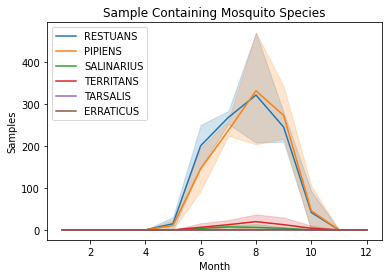

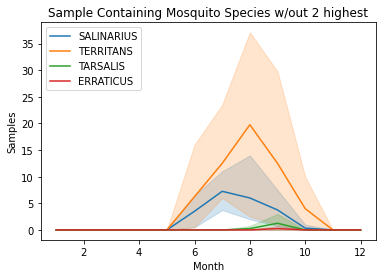

In [20]:
trainplot = train.resample('M').sum()
trainplot['Month'] = trainplot.index.month
trainplot['Year'] = trainplot.index.year

trainplot = trainplot[trainplot.Year.isin([2007,2009,2011,2013])]


specs = ['RESTUANS','PIPIENS','SALINARIUS','TERRITANS','TARSALIS','ERRATICUS']
for s in specs:
    sns.lineplot(data=trainplot,x='Month',y=s)
plt.legend(labels=specs,loc='upper left') 
plt.ylabel('Samples')
plt.title('Sample Containing Mosquito Species')
plt.show()


specs = ['SALINARIUS','TERRITANS','TARSALIS','ERRATICUS']
for s in specs:
    sns.lineplot(data=trainplot,x='Month',y=s)
plt.legend(labels=specs,loc='upper left') 
plt.ylabel('Samples')
plt.title('Sample Containing Mosquito Species w/out 2 highest')
plt.show()

Above are plots of the number of samples containing the mosquito species.  The shaded regions represent the 95% CI from different years. The mosquito species seem to all peak at the same time.  

The most common mosquito species are Restuans and Pipiens and they are most prevelant in August.  The other species are only in a small number of samples. 


I don't believe this is useful at this time. 

Now I'll check the aerial distributions of number of mosquitos and WNV cases

In [21]:
###  Plot mosquito traps data 
def plot_var_on_map(month,year,var):
    #year = '2007'
    #month = '08'
    date = year +'-'+month
    #var='NumMosquitos'

    trainplot = train.loc[date].groupby('Trap',observed=True)['NumMosquitos','WnvPresent'].sum()
    trainplot = trainplot.merge(train[['Trap','Latitude','Longitude']],on = 'Trap',how = 'inner')
    trainplot = trainplot.drop_duplicates()

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)


    plt.scatter(x=trainplot.Longitude,y=trainplot.Latitude,c=trainplot[var])
    plt.colorbar()
    plt.title("{} for {} in {}".format(var,month,year))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

In [22]:
interact(plot_var_on_map,month=['05','06','07','08','09','10','11'],year=['2007','2009','2011','2013'],var=['NumMosquitos','WnvPresent']);

interactive(children=(Dropdown(description='month', options=('05', '06', '07', '08', '09', '10', '11'), value=…

After looking at the WNV positive cases in map view, I have noticed that the WNC cases appear in localized clusters in the city, but those clusters are not consistent through time (probably due to weather and reactive spraying efforts).  

~~I believe a helpful predictive feature for positive cases could be if the trap or a nearby trap had a positive case the week before.  I think this would be good to use, but I am not sure I could implement it when modeling.~~  I will ask Rahul and circle back to this.  
___
_Rahul said not to do this, it would provide bias into the model predictions. However it still seems to me that a trap that had a positive test one week is more likely to have a positive test the next week, and that is the kind of bias I want in the model.  Maybe I can do a test to see if that is the case._

_Rahul also said to not use the spray data.  Spraying data is reactive to the presence of mosquitos/virus and not helpful in prediction.  I'd like to confirm this at some point with the data._

In [23]:
### At some point, circle back to test my idea about previous
### week positive tests

Now I will start integrating the weather data with the training data.  First I need to know the geographic distance between the stations and the traps, I'll use haversine distance.  

In [24]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=3956):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)
    
    BCM edit:
    --
    Returns great circle distance in miles
    
    Only good for small distances, assumes earth is perfect sphere I believe
    --
    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [25]:
weather[['Station','StationLat','StationLong']].drop_duplicates()

,Station,StationLat,StationLong
0,1,41.995,-87.933
1,2,41.786,-87.752


In [26]:
### Create new dataframe of only trap locations and 
### calculate which weather station is closest based on haversine distance
### Finish by merging closest_station with training data

traps = train[['Trap','Latitude','Longitude']].drop_duplicates()

traps['Weather1Lat'] = 41.995
traps['Weather1Long'] = -87.933
traps['Weather2Lat'] = 41.786
traps['Weather2Long'] = -87.752



traps['Haver_1'] = haversine(traps['Latitude'],traps['Longitude'],traps['Weather1Lat'],traps['Weather1Long'])
traps['Haver_2'] = haversine(traps['Latitude'],traps['Longitude'],traps['Weather2Lat'],traps['Weather2Long'])
traps['Station'] = np.where(traps['Haver_1']<=traps['Haver_2'],1,2)
traps['Station_dist'] = traps[['Haver_1','Haver_2']].min(axis=1)

traps = traps[['Trap','Latitude','Longitude','Station','Station_dist']]


train = pd.merge(train,traps,how='left',on=['Trap','Latitude','Longitude'],validate='many_to_one')
train.head(2)


,Date,Trap,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,RESTUANS,...,NumMosquitos,WnvPresent,Year,Month,Week,WnvPerc_yearly,WnvPerc_monthly,WnvPerc_weekly,Station,Station_dist
0,2007-05-29,T002,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,...,2,0.0,2007,5,22,0.106237,0.0,0.0,1,7.325456
1,2007-05-29,T007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,...,1,0.0,2007,5,22,0.106237,0.0,0.0,1,8.401282


That looks pretty good for the training data.  Now I know which station (and how far it is) from the weather data to merge into each trap in the training data.

What I need to do now:
    Create a function to aggregate the weather data for X days to the trap record date and create a weather data set that includes lag times for all relevant features.  Then I can merge these two together based on `Date` and `Station`. Finally I can merge this with the training set on the `Date` and `Station` columns.

In [27]:
train.Date.drop_duplicates().shape

(95,)

In [28]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Station         2944 non-null   int64         
 1   Date            2944 non-null   datetime64[ns]
 2   Tmax            2944 non-null   int64         
 3   Tmin            2944 non-null   int64         
 4   Tavg            2944 non-null   int64         
 5   Depart          2944 non-null   float64       
 6   DewPoint        2944 non-null   int64         
 7   WetBulb         2944 non-null   int64         
 8   Heat            2944 non-null   int64         
 9   Cool            2944 non-null   int64         
 10  CodeSum         2944 non-null   object        
 11  PrecipTotal     2944 non-null   float64       
 12  StnPressure     2944 non-null   float64       
 13  SeaLevel        2944 non-null   float64       
 14  AvgSpeed        2944 non-null   float64       
 15  Sunr

In [29]:
### Create dict that will be features to lag and number of days to lag.
lag_feats = {'Tavg':7,'DewPoint':7,'WetBulb':7,'WindSpeed':5,'AvgSpeed':5,\
             'StnPressure':7,'PrecipTotal':14}

In [30]:
def Create_lag_features(df,lag_feats):
    """
    """
    
    
    ### Split into Station 1 and station 2
    df1 = df[df['Station']==1].sort_values(by = 'Date')
    df2 = df[df['Station']==2].sort_values(by = 'Date')
    
    for dfs in [df1,df2]:
        for feat in lag_feats.keys():
            for day in range(1,1+lag_feats[feat]):
                dfs.loc[:,feat+'_lag'+str(day)] = dfs[feat].shift(day)
    
    return pd.concat([df1,df2]).reset_index(drop=True)

    

Perfect. This function will lag certain features in the weather data set for days up to the value in the dictionary.

In [31]:
weather_lag = Create_lag_features(weather,lag_feats)
weather_lag[['Tavg','Tavg_lag1','Tavg_lag3']].head(4)

,Tavg,Tavg_lag1,Tavg_lag3
0,67,NaN,NaN
1,51,67.0,NaN
2,56,51.0,NaN
3,58,56.0,67.0


In [32]:
### Function for aggregating the last X days of the weather data
### and creating lag features

def AggregateWeatherDays(df,agg_days=[3,7]):
    """
    """
    ### Define columns to aggregate and their method of aggregation
    agg_funcs = {'Tavg':'mean','PrecipTotal':'sum',\
             'DewPoint':'mean','WetBulb':'mean','StnPressure':'mean',\
             'SeaLevel':'mean','AvgSpeed':'mean'}

    ### Isolate weather into two dataframes depending on station
    
    df1 = df[df.Station==1].reset_index(drop=True).sort_index()
    df2 = df[df.Station==2].reset_index(drop=True).sort_index()
        
    ### loop through the two dataframes
    for dfs in [df1,df2]:
        ### loop through the days to aggregate
        for days in agg_days:
            ### loop through the columns to aggregate
            for col in agg_funcs.keys():
                dfs.loc[:,col+'_agg'+str(days)] = dfs.loc[:,col]\
                                    .rolling(days).agg(agg_funcs[col])

    ### concat the two columns and return 
    return pd.concat([df1,df2]).sort_values(by=['Date','Station']).reset_index(drop=True)
                

Great, now I have a function that will aggregate the weather data for dates in the training data set and using a specified number of days to aggregate over.  Now I will apply it, which will add columns to the train dataframe

In [33]:
weather_agg = AggregateWeatherDays(weather)

Now I need to merge the lag weather dataframe with the agg weather data frame, and then finally merge the complete weather dataframe with the train dataframe

In [34]:
weather_complete = pd.merge(weather_lag, weather_agg,suffixes=[None,'_dup'],\
                            how='inner', on=['Date','Station'],\
                           validate='one_to_one')
weather_complete = weather_complete.drop(weather_complete.\
                                         filter(regex='_dup$').\
                                         columns.tolist(),axis=1)
weather_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 2943
Data columns (total 88 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Station            2944 non-null   int64         
 1   Date               2944 non-null   datetime64[ns]
 2   Tmax               2944 non-null   int64         
 3   Tmin               2944 non-null   int64         
 4   Tavg               2944 non-null   int64         
 5   Depart             2944 non-null   float64       
 6   DewPoint           2944 non-null   int64         
 7   WetBulb            2944 non-null   int64         
 8   Heat               2944 non-null   int64         
 9   Cool               2944 non-null   int64         
 10  CodeSum            2944 non-null   object        
 11  PrecipTotal        2944 non-null   float64       
 12  StnPressure        2944 non-null   float64       
 13  SeaLevel           2944 non-null   float64       
 14  AvgSpeed

The complete weather frame looks good, and now contains 117 columns.  Now I will merge it on to the train data.

In [35]:
print('Train shape:',train.shape)
print('Date/Trap duplicates: ',train.duplicated(subset=['Date','Trap']).sum())

Train shape: (4616, 25)
Date/Trap duplicates:  0


In [36]:
train = pd.merge(train,weather_complete, how='left',on=['Date','Station'],validate='many_to_one')

In [37]:
train.head()

,Date,Trap,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,RESTUANS,...,StnPressure_agg3,SeaLevel_agg3,AvgSpeed_agg3,Tavg_agg7,PrecipTotal_agg7,DewPoint_agg7,WetBulb_agg7,StnPressure_agg7,SeaLevel_agg7,AvgSpeed_agg7
0,2007-05-29,T002,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,...,29.386667,30.106667,7.100000,68.000000,1.09,50.571429,58.571429,29.404286,30.125714,9.485714
1,2007-05-29,T007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,...,29.386667,30.106667,7.100000,68.000000,1.09,50.571429,58.571429,29.404286,30.125714,9.485714
2,2007-05-29,T015,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,...,29.386667,30.106667,7.100000,68.000000,1.09,50.571429,58.571429,29.404286,30.125714,9.485714
3,2007-05-29,T045,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,1,...,29.446667,30.093333,7.266667,69.428571,0.46,51.285714,59.142857,29.467143,30.115714,9.171429
4,2007-05-29,T046,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,...,29.446667,30.093333,7.266667,69.428571,0.46,51.285714,59.142857,29.467143,30.115714,9.171429


The training data is now merged with the weather data and everything looks good.

Now I'll try to find some relationships in the data.  Firstly I have seen that the more mosquitos in the trap the more likely it will test positive for WNV.  Let's see if there are any numeric columns that are highly correlated with `NumMosquitos`.
___

<AxesSubplot:>

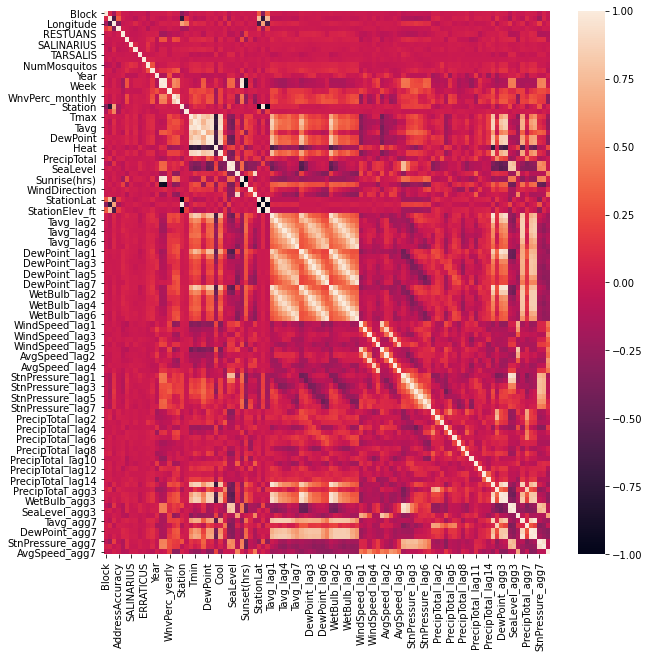

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr())

Nothing appears to correlate strongly with the `NumMosquitos`, that is disappointing. But maybe they will after a transformation...

All of the temperature measures are highly correlative to each other, which isn't suprising given the previous temporal plot.  I probably only need one in my model. I expected `PrecipTotal` to have a higher correlation with `DewPoint`.  

In [39]:
### Define the columns to take in the pair plot
pp_cols=['Tavg','PrecipTotal','DewPoint','Week']

In [40]:
### Set which weather interval we want to look at and modify column names
days=7
pp_cols = [c + '_agg' + str(days) if c not in \
           ['NumMosquitos','WnvPresent','Week','Month','Year'] else c for c in pp_cols]


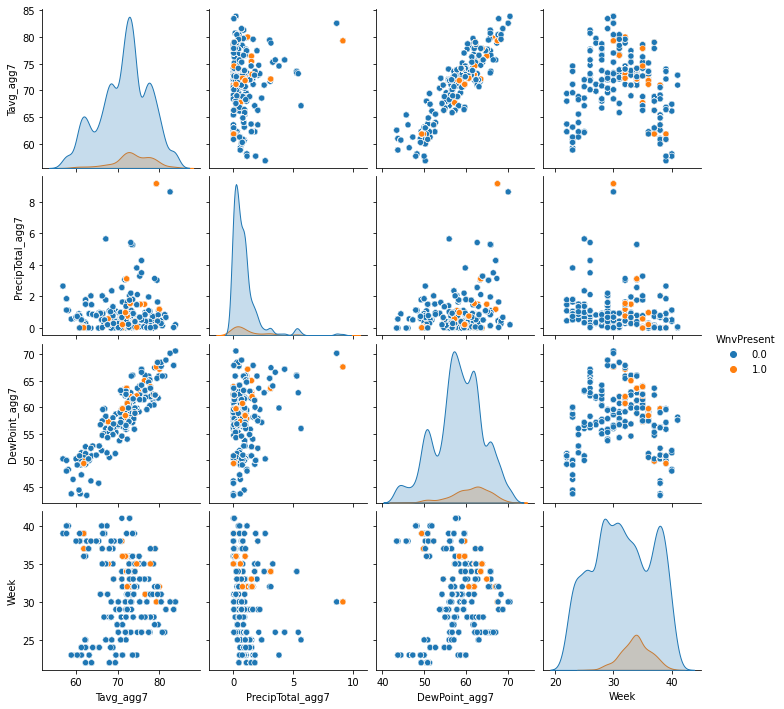

In [41]:
sns.pairplot(data=train,vars=pp_cols,hue='WnvPresent')
#plt.title('Pairplot of {} aggregated weather data'.format(days))
plt.show()

### Pairplot of aggregated weather data colored by positive WNV case

Some observations here:
    - Nearly all of the + WNV cases are on the high end of temperature and on the high end of DewPoint.
    - The Week histograms show that mostly all of the +WNV cases fall between weeks 30 and 40
    - All WNV cases appear to fall after the summer solstice when `Sunrise(hrs)` starts increasing.  
    - There might be a 'sweet-spot for precipitating predicting WNV.  Most of the positive WNV cases fal between 0-4 total inches (14days) and above 10 inches of total precipitation
    

I know that mosqiutos breed in standing water.  I'll explore the precipitation to see if there is a relationship to the positive WNV cases.

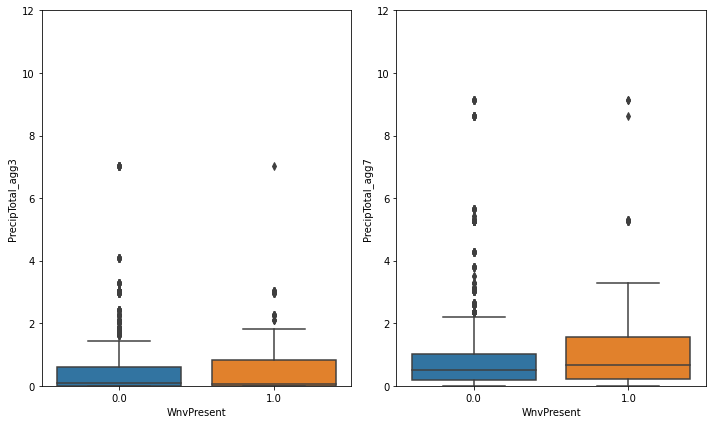

In [42]:
### Precipitation box plot
fg,ax = plt.subplots(1,2,figsize=(10,6),tight_layout=True)

sns.boxplot(data=train,x='WnvPresent',y='PrecipTotal_agg3',ax=ax[0])
sns.boxplot(data=train,x='WnvPresent',y='PrecipTotal_agg7',ax=ax[1])
#sns.boxplot(data=train,x='WnvPresent',y='PrecipTotal_agg14',ax=ax[2])

for i in range(2): ax[i].set_ylim((0,12))

plt.show()

It looks like there is a small difference in precipitation between positive test cases and negative cases.  Let's do a statisical permutation test for the null hypothesis, that the average of the total amount of precipitation 14 days prior to a positive WNV test is the same as for a negative test.

In [43]:
train.groupby('WnvPresent')\
['PrecipTotal_agg3','PrecipTotal_agg7'].mean()

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,PrecipTotal_agg3,PrecipTotal_agg7
WnvPresent,,
0.0,0.456920,0.880900
1.0,0.589091,1.220545


p-value: 0.0


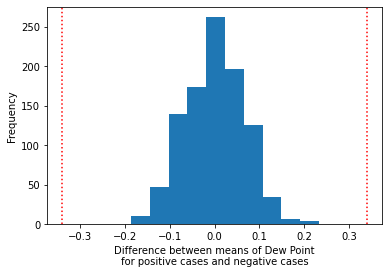

In [44]:
### Permutation test for differnce of means

means = []
for _ in range(1000):
    train['Perm'] = np.random.permutation(train['PrecipTotal_agg7'])
    means.append(train.loc[train.WnvPresent==1,'Perm'].mean() -  train.loc[train.WnvPresent==0,'Perm'].mean())
means = np.array(means)
diff = abs(1.22-0.88)
p=(np.sum(means >= diff)+np.sum(means<=diff*-1))/len(means)
print('p-value: {}'.format(p))
plt.hist(means)
plt.axvline(diff,color='red',linestyle=':')
plt.axvline(diff*-1,color='red',linestyle=':')
plt.xlabel('Difference between means of Dew Point\nfor positive cases and negative cases')
plt.ylabel('Frequency')
train.drop('Perm',axis=1,inplace=True)

There is approximately a 0% chance that the difference in means of total precipitation over the past 14 days for positive WNV tests is the same as for negative tests.  I reject the null hypothesis, so this could be a useful predictive feature. 

I live in Houston and know all about humidity and mosquitos.  In fact as I am working on this the mosquitos are really bad becuase it has been raining and there is a lot of standing water around.  Consequently the dew point/humidity are very high.  Let's look at distributions of the dew point for positive cases and negative cases  

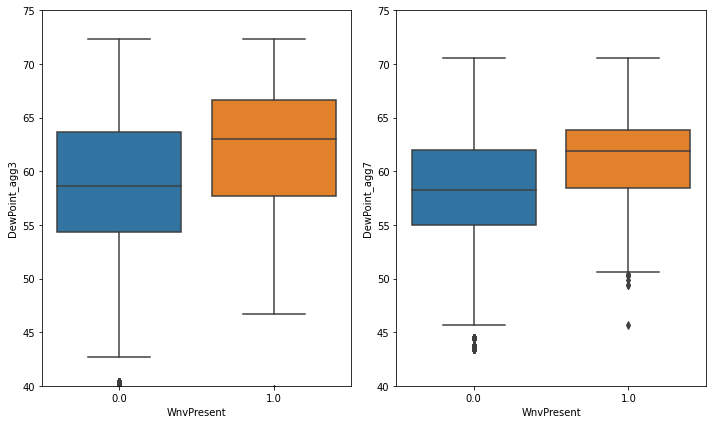

In [45]:
### Box plot of dew point (humidity?) for positive and negative cases
fg,ax = plt.subplots(1,2,figsize=(10,6),tight_layout=True)

sns.boxplot(data=train,x='WnvPresent',y='DewPoint_agg3',ax=ax[0])

sns.boxplot(data=train,x='WnvPresent',y='DewPoint_agg7',ax=ax[1])

#sns.boxplot(data=train,x='WnvPresent',y='DewPoint_agg14',ax=ax[2])

for i in range(2): ax[i].set_ylim((40,75))

plt.show()


There is an observable difference for each time window, especially looking at the 14 days prior to the sample.  I'll do a permutation test to make sure where the null hypothesis is that the mean dew point for negative cases is equal to the mean dew point for positive cases. 

In [46]:
train.groupby('WnvPresent')['DewPoint_agg3','DewPoint_agg7'].mean()

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,DewPoint_agg3,DewPoint_agg7
WnvPresent,,
0.0,58.362247,58.183678
1.0,61.972294,61.040074


p-value: 0.0


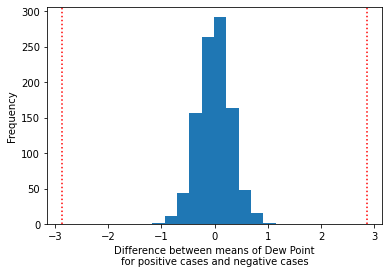

In [47]:
### Permutation test for differnce of means

means = []
for _ in range(1000):
    train['Perm'] = np.random.permutation(train['DewPoint_agg7'])
    means.append(train.loc[train.WnvPresent==1,'Perm'].mean() -  train.loc[train.WnvPresent==0,'Perm'].mean())
means = np.array(means)
diff = abs(61.04-58.18)
p=(np.sum(means >= diff)+np.sum(means<=diff*-1))/len(means)
print('p-value: {}'.format(p))
plt.hist(means)
plt.axvline(diff,color='red',linestyle=':')
plt.axvline(diff*-1,color='red',linestyle=':')
plt.xlabel('Difference between means of Dew Point\nfor positive cases and negative cases')
plt.ylabel('Frequency')
train.drop('Perm',axis=1,inplace=True)

The permutation test demonstrates that there is a ~0% chance that the aggregated Dew points average is the same for positive WNV cases as it is for negative cases.  I can reject the null hypothesis, and therefore this is probably a meaningful feature for predicting the presence of WNV.

I would expect that precipitation and dew point are correlative.  The Dew Point seems to be a more robust variable to distinguish positive and negative cases.  This is becuase, unlike the precipitation, for Dew Point there are significant differences in the median as well as the mean.  

The Dew Points are normally distributed whereas the precipitations are not.  The precipitation distributions are right skewed, because they are limited at 0. 

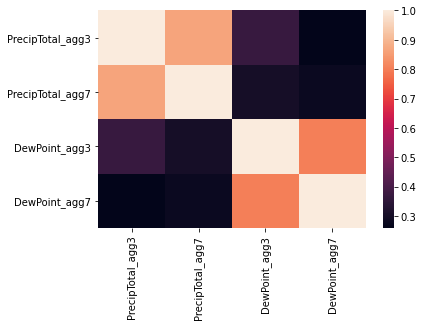

In [48]:
sns.heatmap(train[['PrecipTotal_agg3','PrecipTotal_agg7','DewPoint_agg3','DewPoint_agg7']].corr());

Actually it looks like the dew point and precipitation have a low correlation. Perhaps I could use both in my model.
___
While I have never been to Chicago, I know it's nickname is the Windy City.  I would guess that there would be fewer mosquitos around and hence less virus during times of high wind.  Let's see.

As I suspected! It appears that presence of WNV is associated with lower wind speeds, especially looking at the average of the last 7 and 14 days.  This also looks like a useful feature. Does wind direction matter?

I do not see any trend to the positive WNV cases in the wind direction data. 

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Columns: 111 entries, Date to AvgSpeed_agg7
dtypes: datetime64[ns](1), float64(83), int32(2), int64(20), object(5)
memory usage: 4.0+ MB


In [50]:
### Finally I will create a new feature called daylight that will
### capture the number of daylight hours.  This will reduce two features to one
train['Daylight'] = train['Sunset(hrs)'] - train['Sunrise(hrs)']
train = train.drop(['Sunrise(hrs)','Sunset(hrs)'],axis=1)



# Summary
The worst time of the year for WNV positive cases is from weeks 31-36. This time is marked by high average temperatures and a high dew point (especially for the bad outbreak of 2007). The upticks in weekly precipitation also seem to line up with the spikes in mosquitos/WNV.

Aggregated recipitation, dew point and wind speed values all showed statistically significant differences between negative WNV cases and positive cases.  The effect is generally greater on the longer aggregation windows (7 days and 14 days).  

The stacked bar plots indicate the number of Fog, Rain, and thunderstorm events in the past 7 days could be helpful predictors of positive cases.  




In [51]:
raise('stop')

TypeError: exceptions must derive from BaseException

In [52]:
train.to_csv('train_w_aggregated_weather.csv')